In [2]:
import math
import pickle
import time
from functools import reduce
from pandarallel import pandarallel



import dask.dataframe as ddf
import jqdatasdk as jq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import plotly.graph_objects as go
from csmarapi.CsmarService import CsmarService
from plotly.subplots import make_subplots
from scipy import stats
from utils.my_cache import cache_wrapper

csmar = CsmarService()
from csmarapi.ReportUtil import ReportUtil
pandarallel.initialize()
# jq.auth('13764432461', 'Swisschina6')
# csmar.login('wuhh@pbcsf.tsinghua.edu.cn', 'whh8803582')

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [3]:
def yearly_return(result):
    return str((((result.params[0] + 1) ** 12 - 1) * 100).round(2)) + '%'

def float_to_percent(float : np.float64):
    return str((float * 100).round(3)) + '%'

## **I. Data**

**Research**

- Most Data (nav/dividend/split ratio/asset allocation) : `CSMAR`

- Fund classification : `JoinQuant`

- Fund start date: `JoinQuant`

- SVC related: `previous research`

**Validation**

- `AMAC` : [2020 yearly report, page 15](https://www.amac.org.cn/researchstatistics/publication/zgzqtzjjynb/202104/t20210419_11390.html), for market statistic

- `Win.d` : classification/share/nav, for market statistic; stock fund adjusted net asset value (2005/6-2019/6)

<span style="color:blue">Data is sound, carefully verified and available to fetch</span>

AMAC

In [6]:
amac = pd.read_csv('data/AMAC/amac.csv', sep='\t', index_col=0).astype(float)
amac.index = pd.to_datetime(amac.index.astype(str)) + pd.Timedelta('180 days')

JoinQuant

In [7]:
@cache_wrapper(expire = 60 * 60 * 24 * 7)
# cache to avoid unnecessary traffic
def brief_of_funds(frequency : str = time.strftime('%W')) -> pd.DataFrame:
    return jq.get_all_securities(['fund', 'open_fund'], time.strftime('%Y%m%d'))


@cache_wrapper(expire = 60 * 60 * 24 * 7)
def main_info(fund_codes, frequency : str = time.strftime('%W')) -> pd.DataFrame:
    '''
    if you want to modify this function, delete cache and go on
    '''
    limit = jq.DBTable.RESULT_ROWS_LIMIT
    fund_code_cuts = np.array_split(fund_codes, math.ceil(len(fund_codes) / limit))
    full_table_cuts = []
    for code_cut in fund_code_cuts:
        # NOTE `in` is not applicable in filter, use `in_()` defined by joinquant
        table_cut = jq.finance.run_query(jq.query(jq.finance.FUND_MAIN_INFO).filter(jq.finance.FUND_MAIN_INFO.main_code.in_(code_cut)))
        full_table_cuts.append(table_cut)
    full_table = pd.concat(full_table_cuts).reset_index(drop=True)
    full_table['start_date'] = full_table.start_date.astype(np.datetime64).dt.to_period('M')
    return full_table


In [8]:
# run weekly
brief = brief_of_funds()
fund_codes = brief.index.str.split('.').str[0]
fund_main_info = main_info(fund_codes)

fund_main_info_ = fund_main_info[['main_code', 'underlying_asset_type']]

Win.d

In [9]:
wind_share_nav = pd.read_excel('data/Win.d/wind_share_nav.xlsx', sheet_name='Sheet1')
wind_classification = wind_share_nav[['证券代码', '投资类型(一级分类)']]
wind_share_nav = pd.DataFrame(data=wind_share_nav.iloc[:, 3:].values, index=wind_share_nav.证券代码.values, \
    columns = pd.MultiIndex.from_tuples(list(map(lambda x: (x[:4], pd.to_datetime(x[12:22])), wind_share_nav.columns[3:])))).T.sort_index()
wind_share_nav.index = wind_share_nav.index.set_levels(wind_share_nav.index.levels[1].to_period('M'), level=1)


stock_fund_verify = pd.read_excel('data/Win.d/stock_fund_adj_nav.xlsx')
stock_fund_verify.columns = np.concatenate([stock_fund_verify.columns[:2].values, stock_fund_verify.columns[2:].str[-17:-7]])
stock_fund_verify.index = stock_fund_verify.iloc[:, 0].str[:-3]
stock_fund_verify = stock_fund_verify.iloc[:, 2:]
stock_fund_verify.columns = pd.to_datetime(stock_fund_verify.columns).to_period('M')
stock_fund_verify = stock_fund_verify.T.sort_index()
stock_fund_verify.index.name = 'Date'
stock_fund_verify.columns.name = ''

In [10]:
adj_nav_verify = pd.read_excel('data/Win.d/2016-3_adj_nav.xlsx')

CSMAR

In [11]:
maininfo = pd.read_csv('data/CSMAR/FUND_MainInfo.csv', parse_dates=['InceptionDate'])
maininfo['InceptionDate'] = maininfo.InceptionDate.dt.to_period('M')

symbol_code_mapping = pd.read_csv('data/CSMAR/FUND_FundCodeInfo.csv')
symbol_code_mapping = symbol_code_mapping[['MasterFundCode', 'Symbol']].drop_duplicates()
symbol_code_mapping['Symbol'] = symbol_code_mapping.Symbol.astype(str).str.zfill(6)

share_info = pd.read_csv('data/CSMAR/Fund_ShareChange.csv', parse_dates=['EndDate'])
share_info = share_info.rename(columns={'EndDate': 'Date'})
share_info['Date'] = share_info.Date.dt.to_period('M')
share_info['Symbol'] = share_info.Symbol.astype(str).str.zfill(6)
# share_info = share_info.set_index('Date').sort_index()

nav_daily = ddf.read_csv('data/CSMAR/daily_nav/*').compute()
nav_daily = nav_daily.rename(columns={'TradingDate': 'Date'})
# * heavy time complexity
# * if change Symbol to String now, program will be much slower
# nav_daily['Symbol'] = nav_daily.Symbol.astype(str).str.zfill(6)
nav_daily['Date'] = pd.to_datetime(nav_daily.Date)
# nav_daily = nav_daily.set_index('Date')[['Symbol', 'NAV']].sort_index()

fund_dividend = pd.read_csv('data/CSMAR/Fund_FundDividend.csv', parse_dates=['PrimaryExDividendDate', 'SecondaryExDividendDate'])
fund_dividend['Symbol'] = fund_dividend.Symbol.astype(str).str.zfill(6)
ExDividendMonth = fund_dividend.PrimaryExDividendDate.copy()
ExDividendMonth.name = 'ExDividendMonth'
ExDividendMonth[ExDividendMonth.isnull()] = fund_dividend.SecondaryExDividendDate[ExDividendMonth.isnull()].copy()
fund_dividend['ExDividendMonth'] = ExDividendMonth
fund_dividend = fund_dividend[['Symbol', 'ExDividendMonth', 'DividendperShare']]
fund_dividend = fund_dividend.rename(columns={'ExDividendMonth': 'Date'})
fund_dividend['DividendperShare'] = fund_dividend.DividendperShare.fillna(0)
fund_dividend['Date'] = fund_dividend.Date.dt.to_period('M')
fund_dividend = pd.DataFrame(fund_dividend.groupby(['Symbol', 'Date']).sum().to_records())
# fund_dividend = fund_dividend.set_index('Date').sort_index()

resolution = pd.read_csv('data/CSMAR/Fund_Resolution.csv', parse_dates=['DeclareDate'])
resolution['Symbol'] = resolution.Symbol.astype(str).str.zfill(6)
resolution = resolution.rename(columns={'DeclareDate': 'Date'})
resolution['SplitRatio'] = resolution.SplitRatio.fillna(1)
resolution['Date'] = resolution.Date.dt.to_period('M')
resolution = pd.DataFrame(resolution.groupby(['Symbol', 'Date']).prod().to_records())
# resolution = resolution.set_index('Date').sort_index()

allocation = pd.read_csv('data/CSMAR/Fund_Allocation.csv', parse_dates=['EndDate'])
allocation = allocation.rename(columns={'EndDate': 'Date'})
allocation['Date'] = allocation.Date.dt.to_period('M')
# allocation = allocation.set_index('Date').sort_index()


SVC

In [12]:
svc_source = pickle.load(open('data/SVC/CH3_Monthly.pkl', 'rb'))
svc_source['Date'] = pd.to_datetime(svc_source[['year', 'month']].assign(day=1)).dt.to_period('M')
svc_source = svc_source.set_index('Date')

## **II. Market Statistic**

split Win.d data

|       | share            | nav            |
| ----- | ---------------- | -------------- |
| all | all fund share | all fund nav |
| blend | blend fund share | blend fund nav |

In [13]:
wind_share = wind_share_nav.loc['基金份额', slice(None)]
wind_share.columns = wind_share.columns.str.split('.').str[0]
wind_share = wind_share[ ~ wind_share.index.duplicated(keep='last')]

In [14]:
wind_nav = wind_share_nav.loc['单位净值', slice(None)]
wind_nav.columns = wind_nav.columns.str.split('.').str[0]
wind_nav = wind_nav[ ~ wind_nav.index.duplicated(keep='last')]

In [15]:
wind_stock_fund_share = wind_share.T[(wind_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_blend_fund_share = wind_share.T[(wind_classification['投资类型(一级分类)'] == '混合型基金').values].T

wind_stock_fund_nav = wind_nav.T[(wind_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_blend_fund_nav = wind_nav.T[(wind_classification['投资类型(一级分类)'] == '混合型基金').values].T

make Win.d data plottable

In [16]:
wind_stock_fund_num = pd.notna(wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_num.index = wind_stock_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_blend_fund_num = pd.notna(wind_blend_fund_nav).sum(axis=1)
wind_blend_fund_num.index = wind_blend_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_stock_fund_mkt_value = (wind_stock_fund_share * wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_mkt_value.index  = wind_stock_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_blend_fund_mkt_value = (wind_blend_fund_share * wind_blend_fund_nav).sum(axis=1)
wind_blend_fund_mkt_value.index  = wind_blend_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)


align JoinQuant && CSMAR data

In [17]:
# may cache this cell to speed up
nav_monthly = nav_daily.groupby('Symbol').parallel_apply(lambda x: x.set_index('Date').resample('M').last()).NAV
nav_monthly = nav_monthly.unstack(level=0)
nav_monthly.index = nav_monthly.index.to_period('M')
nav_monthly.columns = nav_monthly.columns.astype(str).str.zfill(6)

In [18]:
share_info_ = share_info.drop_duplicates(subset=['Symbol', 'Date']).pivot(index='Date', columns='Symbol', values='EndDateShares')

In [19]:
selected_month = 6

share_info_6 = share_info_[share_info_.index.month == selected_month]
nav_monthly_6 = nav_monthly[nav_monthly.index.month == selected_month]

csmar_blend_code_6 = np.intersect1d(nav_monthly_6.columns, fund_main_info_[fund_main_info_.underlying_asset_type == '混合型'].main_code.values)
csmar_blend_code_6 = np.intersect1d(csmar_blend_code_6, share_info_6.columns)

csmar_stock_code_6 = np.intersect1d(nav_monthly_6.columns, fund_main_info_[fund_main_info_.underlying_asset_type == '股票型'].main_code.values)
csmar_stock_code_6 = np.intersect1d(csmar_stock_code_6, share_info_6.columns)

csmar_co_time_6 = np.intersect1d(share_info_6.index, nav_monthly_6.index)

In [20]:
csmar_blend_mkt_value_jq_classify = (share_info_6.loc[csmar_co_time_6, csmar_blend_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_blend_code_6]).sum(axis=1)
csmar_stock_mkt_value_jq_classify = (share_info_6.loc[csmar_co_time_6, csmar_stock_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_stock_code_6]).sum(axis=1)

csmar_stock_mkt_value_jq_classify.index = csmar_stock_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)
csmar_blend_mkt_value_jq_classify.index = csmar_blend_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

stock funds market value

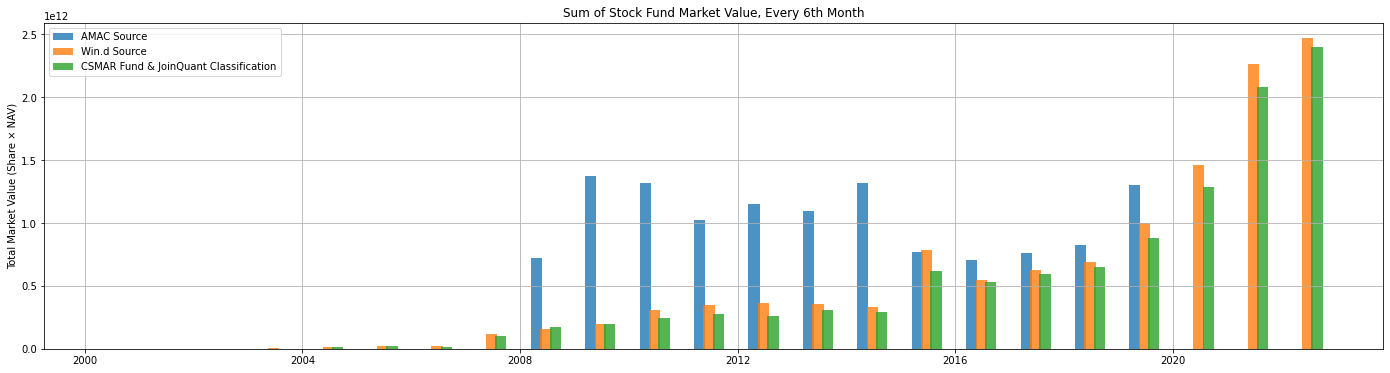

In [21]:
plt.figure(figsize=(24, 6))
plt.bar(amac.股票基金.index - pd.Timedelta('10W'), amac.股票基金.values * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_stock_fund_mkt_value.index - pd.Timedelta('1W'), wind_stock_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_stock_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_stock_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Stock Fund Market Value, Every 6th Month')
plt.legend()

blend funds market value

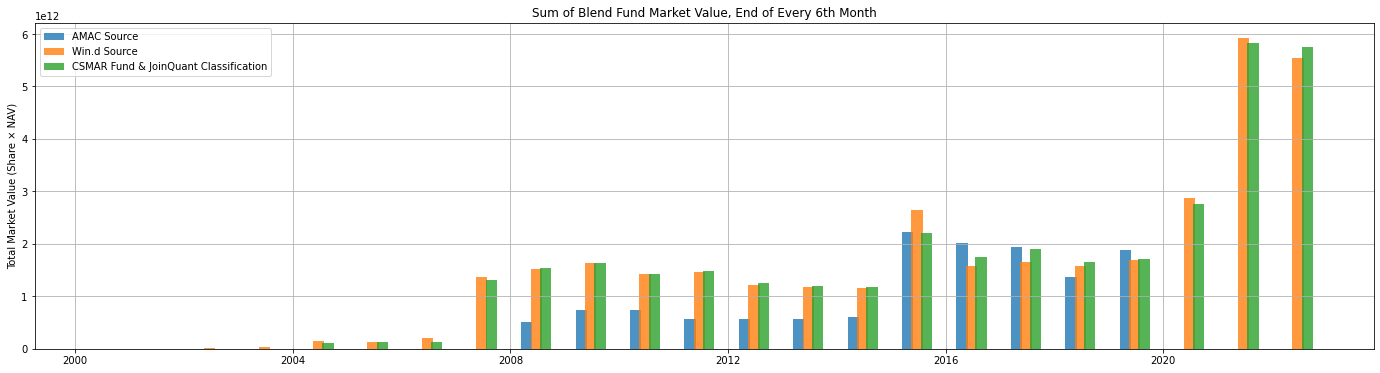

In [22]:
plt.figure(figsize=(24, 6))
plt.bar(amac.混合基金.index - pd.Timedelta('10W'), amac.混合基金.values * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_blend_fund_mkt_value.index - pd.Timedelta('1W'), wind_blend_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_blend_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Blend Fund Market Value, End of Every 6th Month')
plt.legend()

(stock + blend) funds market value

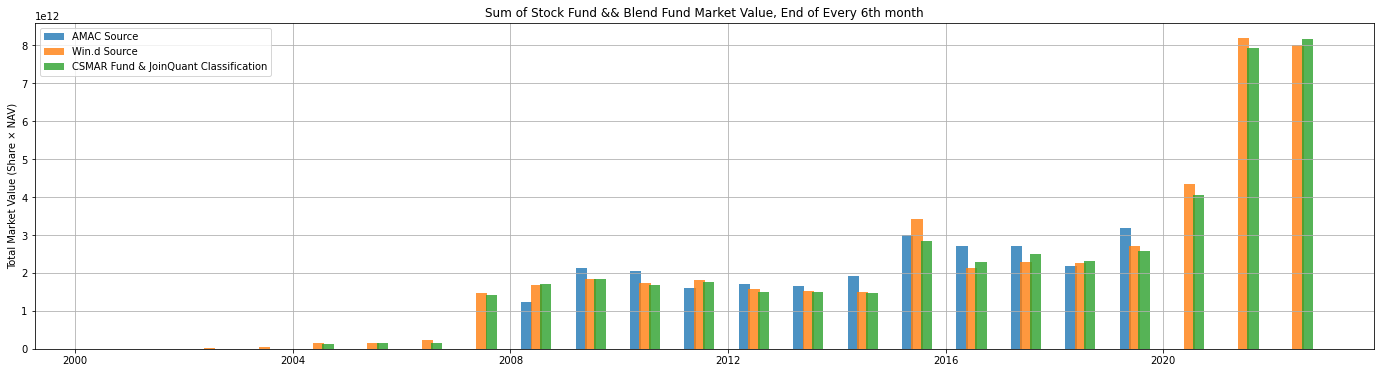

In [23]:
plt.figure(figsize=(24, 6))
plt.bar(amac.混合基金.index - pd.Timedelta('10W'), (amac.混合基金.values + amac.股票基金.values) * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_blend_fund_mkt_value.index - pd.Timedelta('1W'), \
     wind_blend_fund_mkt_value.values + wind_stock_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('8W'), \
     csmar_blend_mkt_value_jq_classify.values + csmar_stock_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Stock Fund && Blend Fund Market Value, End of Every 6th month')
plt.legend()

fund counts

In [24]:
csmar_stock_fund_count = nav_monthly.loc[:, csmar_stock_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_stock_fund_count.index = csmar_stock_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

csmar_blend_fund_count = nav_monthly.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_blend_fund_count.index = csmar_blend_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

integrated plot

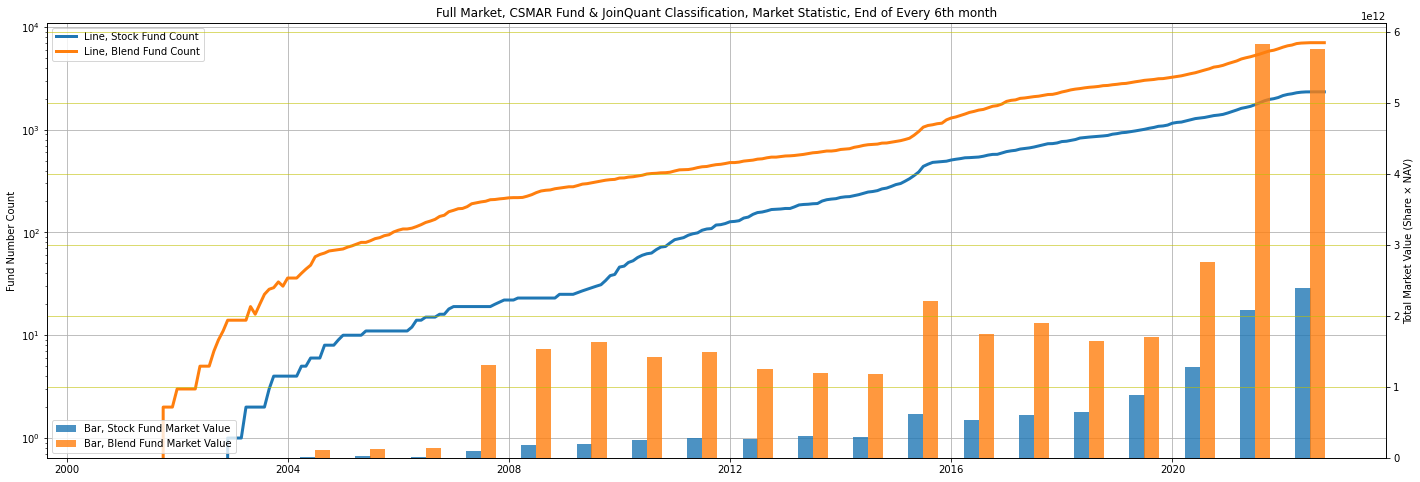

In [25]:
fig, ax1 = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(24)

nav_monthly_6.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)

ax1.plot(csmar_stock_fund_count, linewidth=3, label='Line, Stock Fund Count')
ax1.plot(csmar_blend_fund_count, linewidth=3, label='Line, Blend Fund Count')

ax1.set_yscale('log')
ax1.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4])
ax1.grid()
ax1.set_ylabel('Fund Number Count')

ax2 = ax1.twinx()

plt.bar(csmar_stock_mkt_value_jq_classify.index - pd.Timedelta('7W'), \
     csmar_stock_mkt_value_jq_classify.values, width=100, label='Bar, Stock Fund Market Value', alpha=.8)

plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('7W'), \
     csmar_blend_mkt_value_jq_classify.values, width=100, label='Bar, Blend Fund Market Value', alpha=.8)

plt.title('Full Market, CSMAR Fund & JoinQuant Classification, Market Statistic, End of Every 6th month')

ax2.grid(color='y', alpha=.7)
plt.ylabel('Total Market Value (Share × NAV)')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

pass

## **III. Filters**

### preview

In [26]:
csmar_jq_co_fund = np.intersect1d(np.char.zfill(nav_daily.Symbol.unique().astype(str), 6), fund_main_info.main_code)
csmar_jq_co_fund = pd.Series(csmar_jq_co_fund, name='main_code')

final_main_info = pd.merge(fund_main_info, csmar_jq_co_fund, on='main_code')[['main_code', 'name', 'operate_mode', 'underlying_asset_type', 'invest_style', 'start_date']]

In [27]:
specs = [[{'type':'domain'}] * 2]
fig = make_subplots(rows=1, cols=2, specs=specs, subplot_titles=['JoinQuant Asset Type', 'JoinQuant Operation Mode'])
fig.add_trace(go.Pie(labels=final_main_info.underlying_asset_type.value_counts().index, values=final_main_info.underlying_asset_type.value_counts().values), 1, 1)
fig.add_trace(go.Pie(labels=final_main_info.operate_mode.value_counts().index, values=final_main_info.operate_mode.value_counts().values), 1, 2)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update(layout_showlegend=False)
fig.update_layout(width=1200, height=500)

### 1. static filtering

（1）基金类别为“股票型基金”或“混合型基金”；


（2）基金非 ETF 类基金、非 QDII 类基金

<!-- （4）主动管理标识为 1 或者为空； -->

In [28]:
final_main_info

,main_code,name,operate_mode,underlying_asset_type,invest_style,start_date
0,000001,华夏成长,开放式基金,混合型,偏股混合型,2001-12
1,000003,中海可转债债券,开放式基金,债券型,二级债基,2013-03
2,000004,中海可转债C,开放式基金,债券型,二级债基,2013-03
3,000005,嘉实增强信用,开放式基金,债券型,长期纯债型,2013-03
4,000006,西部利得量化成长混合,开放式基金,混合型,偏股混合型,2019-03
...,...,...,...,...,...,...
16388,968083,汇丰亚洲高入息债券BM2类–人民币,开放式基金,债券型,中短期纯债型,2020-04
16389,968084,汇丰亚洲高入息债券BM3O类–人民币,开放式基金,债券型,中短期纯债型,2020-04
16390,968085,汇丰亚洲高入息债券BC类–港元,开放式基金,债券型,中短期纯债型,2020-04
16391,968086,汇丰亚洲高入息债券BM2类–港元,开放式基金,债券型,中短期纯债型,2020-04


In [29]:
filter_1 = np.logical_or(final_main_info.underlying_asset_type == '股票型', final_main_info.underlying_asset_type == '混合型')
filter_2 = np.logical_and(final_main_info.operate_mode != 'ETF', final_main_info.operate_mode != 'QDII')

filters = [(1, filter_1), (2, filter_2)]
np.array(list(map(lambda _: _[1].sum(), filters))) / len(final_main_info)

# proportional data left

array([0.62014274, 0.93192216])

In [30]:
def func(previous, now):
    if type(previous) == tuple:
        print(f'filter {previous[0]}: {len(final_main_info)} to {previous[1].sum()}')
        temp = np.logical_and(previous[1], now[1])
        print(f'filter {now[0]}: {previous[1].sum()} to {temp.sum()}')
        return temp
    else:
        temp = np.logical_and(previous, now[1])
        print(f'filter {now[0]}: {previous.sum()} to {temp.sum()}')
        return temp


filters_ = reduce(func, filters)

filter 1: 16393 to 10166
filter 2: 10166 to 9255


In [31]:
final_main_info_ = final_main_info[filters_]
final_main_info_.set_index('main_code').sort_index()

,name,operate_mode,underlying_asset_type,invest_style,start_date
main_code,,,,,
000001,华夏成长,开放式基金,混合型,偏股混合型,2001-12
000006,西部利得量化成长混合,开放式基金,混合型,偏股混合型,2019-03
000011,华夏大盘,开放式基金,混合型,偏股混合型,2004-08
000017,财通可持续混合,开放式基金,混合型,偏股混合型,2013-03
000020,景顺品质,开放式基金,混合型,偏股混合型,2013-03
...,...,...,...,...,...
968045,摩根股息人民币对冲(每月派息),开放式基金,股票型,普通股票型,2019-03
968046,摩根股息美元(累计),开放式基金,股票型,普通股票型,2019-03
968047,摩根股息美元(每月派息),开放式基金,股票型,普通股票型,2019-03


### 2. big table

from `code` indexed only to `code-month` multiIndex

In [32]:
indexes = pd.MultiIndex.from_product([final_main_info_.main_code.sort_values().values, pd.date_range('2000-1', '2022-10', freq='M')])
temp_codes = indexes.get_level_values(0)
temp_date = indexes.get_level_values(1)
main_data = pd.DataFrame(index=indexes)
main_data['main_code'] = temp_codes
main_data['Date'] = temp_date.to_period('M')
main_data = pd.merge(main_data, final_main_info_, on='main_code')
main_data = main_data.rename(columns={'main_code': 'Symbol'})
main_data = main_data.set_index(['Symbol', 'Date'])
main_data = main_data.loc[nav_monthly[final_main_info_.main_code.sort_values().values].stack().index.swaplevel()].sort_index()
main_data

name operate_mode underlying_asset_type invest_style  \
Symbol Date                                                                     
000001 2001-12           华夏成长        开放式基金                   混合型        偏股混合型   
       2002-01           华夏成长        开放式基金                   混合型        偏股混合型   
       2002-02           华夏成长        开放式基金                   混合型        偏股混合型   
       2002-03           华夏成长        开放式基金                   混合型        偏股混合型   
       2002-04           华夏成长        开放式基金                   混合型        偏股混合型   
...                       ...          ...                   ...          ...   
968049 2022-05  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   
       2022-06  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   
       2022-07  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   
       2022-08  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   
       2022-09  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   

               start_date  
Symbol Date                
000001 2001-12    2001-12  
       2002-01    2001-12  
       2002-02    2001-12  
       2002-03    2001-12  
       2002-04    2001-12  
...                   ...  
968049 2022-05    2019-03  
       2022-06    2019-03  
       2022-07    2019-03  
       2022-08    2019-03  
       2022-09    2019-03  

[418550 rows x 5 columns]

### 3. dynamic filtering

（3）基金上市时间超过一年

（4）最近一次**二季度报/年报/半年报**~~年报或半年报~~披露的中国市场股票持股比例超过总管理规模的30%

In [33]:
main_data = main_data[main_data.index.get_level_values(1) >= main_data.start_date + pd.offsets.MonthEnd(12)]
record_shape = len(main_data.index.get_level_values(0).unique())
f'in view of 2022, filter 3: {len(final_main_info_)} to {record_shape}'

'in view of 2022, filter 3: 9255 to 7159'

*problem*: annual report or semi-annual report not available before 2008

*reason*: regulation rule changed

*solve*: add second quarter report

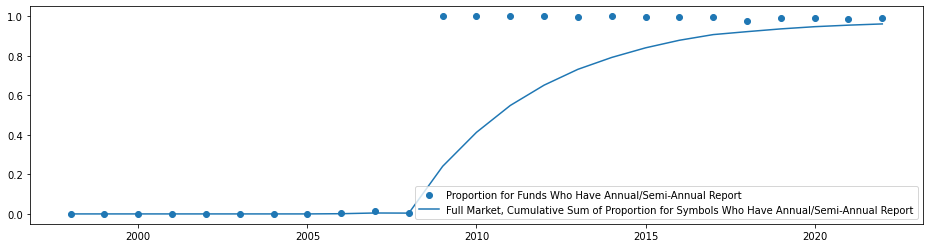

In [34]:
allocation['report_type_check'] = allocation.Date.dt.year
report_type_check = allocation.groupby(['MasterFundCode', 'report_type_check']).apply(lambda temp : 5 in temp.ReportTypeID.values or 6 in temp.ReportTypeID.values)
plt.figure(figsize=(16,4))
report_type_check_ = report_type_check.groupby(level=1).apply(lambda temp: temp.sum() / len(temp))
year_report_count = report_type_check.groupby(level=1).apply(lambda temp: temp.sum())
total_report_count = report_type_check.groupby(level=1).apply(lambda temp: len(temp))
plt.scatter(x=report_type_check_.index, y=report_type_check_.values, label='Proportion for Funds Who Have Annual/Semi-Annual Report')
temp = year_report_count.cumsum() / total_report_count.cumsum()
plt.plot(temp.index, temp.values, label='Full Market, Cumulative Sum of Proportion for Symbols Who Have Annual/Semi-Annual Report')
plt.legend()
pass

<img src="image/README/2008_search.png" alt="drawing" width="500"/> <img src="image/README/2009_search.png" alt="drawing" width="508"/>

[中国证券监督管理委员会公告〔2008〕第4号](http://www.gov.cn/zwgk/2008-02/21/content_896020.htm)


使用存在二季度报/年报/半年报的数据

In [35]:
allocation_ = allocation[allocation.ReportTypeID.isin([2, 5, 6])]
allocation_ = pd.merge(allocation_, symbol_code_mapping, on='MasterFundCode', how='left')
allocation_ = allocation_[allocation_.Symbol.isin(main_data.index.get_level_values(0).unique())]
main_data = main_data.loc[allocation_.Symbol.unique(), slice(None)]

中国市场股票持股比例超过总管理规模30%

In [36]:
filter_4 = allocation_[(allocation_.Equity / allocation_.TotalAsset) > .3]
co_index = np.intersect1d(filter_4.set_index(['Symbol', 'Date']).index, main_data.index)
main_data['filter_4'] = np.nan
main_data.loc[main_data.index.get_level_values(1).month == 6, 'filter_4'] = False
main_data.loc[co_index, 'filter_4'] = True
main_data = main_data.groupby(level=0).fillna(method='ffill').fillna(False)
main_data = main_data[main_data.filter_4].drop('filter_4', axis=1)
main_data

name operate_mode underlying_asset_type invest_style  \
Symbol Date                                                                     
000001 2003-06           华夏成长        开放式基金                   混合型        偏股混合型   
       2003-07           华夏成长        开放式基金                   混合型        偏股混合型   
       2003-08           华夏成长        开放式基金                   混合型        偏股混合型   
       2003-09           华夏成长        开放式基金                   混合型        偏股混合型   
       2003-10           华夏成长        开放式基金                   混合型        偏股混合型   
...                       ...          ...                   ...          ...   
952009 2022-05  国泰君安君得鑫2年持有混合        封闭式基金                   混合型        偏股混合型   
       2022-06  国泰君安君得鑫2年持有混合        封闭式基金                   混合型        偏股混合型   
       2022-07  国泰君安君得鑫2年持有混合        封闭式基金                   混合型        偏股混合型   
       2022-08  国泰君安君得鑫2年持有混合        封闭式基金                   混合型        偏股混合型   
       2022-09  国泰君安君得鑫2年持有混合        封闭式基金                   混合型        偏股混合型   

               start_date  
Symbol Date                
000001 2003-06    2001-12  
       2003-07    2001-12  
       2003-08    2001-12  
       2003-09    2001-12  
       2003-10    2001-12  
...                   ...  
952009 2022-05    2020-01  
       2022-06    2020-01  
       2022-07    2020-01  
       2022-08    2020-01  
       2022-09    2020-01  

[235912 rows x 5 columns]

In [37]:
f'in view of all time span, filter 4: {record_shape} to {len(main_data.index.get_level_values(0).unique())}'

'in view of all time span, filter 4: 7159 to 5291'

### 4. full data

reset nav

In [38]:
nav_monthly_ = pd.Series(nav_monthly.stack().swaplevel(), name='NAV')
nav_monthly_ = pd.DataFrame(nav_monthly_).reset_index()

merge data

In [39]:
main_data = pd.merge(main_data, nav_monthly_, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, fund_dividend, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, resolution, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])

handle NA

In [40]:
main_data['NAV'] = main_data.groupby(level=0).apply(lambda x: x.NAV.fillna(method='ffill')).droplevel(0)
main_data['DividendperShare'] = main_data.DividendperShare.fillna(0)
main_data['SplitRatio'] = main_data.SplitRatio.fillna(1)

combine csmar category

In [41]:
csmar_category_symbol_mapping = pd.merge(maininfo[['MasterFundCode', 'Category']].drop_duplicates(), \
    symbol_code_mapping, on='MasterFundCode', how='left')[['Category', 'Symbol']]
csmar_category_symbol_mapping = csmar_category_symbol_mapping.drop_duplicates().reset_index(drop=True)
csmar_category_symbol_mapping = csmar_category_symbol_mapping.groupby('Symbol').last()

main_data = pd.merge(main_data.reset_index(), csmar_category_symbol_mapping, on='Symbol').set_index(['Symbol', 'Date'])
main_data

name operate_mode underlying_asset_type invest_style  \
Symbol Date                                                                     
000001 2003-06           华夏成长        开放式基金                   混合型        偏股混合型   
       2003-07           华夏成长        开放式基金                   混合型        偏股混合型   
       2003-08           华夏成长        开放式基金                   混合型        偏股混合型   
       2003-09           华夏成长        开放式基金                   混合型        偏股混合型   
       2003-10           华夏成长        开放式基金                   混合型        偏股混合型   
...                       ...          ...                   ...          ...   
952009 2022-05  国泰君安君得鑫2年持有混合        封闭式基金                   混合型        偏股混合型   
       2022-06  国泰君安君得鑫2年持有混合        封闭式基金                   混合型        偏股混合型   
       2022-07  国泰君安君得鑫2年持有混合        封闭式基金                   混合型        偏股混合型   
       2022-08  国泰君安君得鑫2年持有混合        封闭式基金                   混合型        偏股混合型   
       2022-09  国泰君安君得鑫2年持有混合        封闭式基金                   混合型        偏股混合型   

               start_date     NAV  DividendperShare  SplitRatio Category  
Symbol Date                                                               
000001 2003-06    2001-12  0.9730             0.033         1.0    混合型基金  
       2003-07    2001-12  0.9860             0.000         1.0    混合型基金  
       2003-08    2001-12  0.9540             0.000         1.0    混合型基金  
       2003-09    2001-12  0.9200             0.000         1.0    混合型基金  
       2003-10    2001-12  0.9360             0.000         1.0    混合型基金  
...                   ...     ...               ...         ...      ...  
952009 2022-05    2020-01  1.7120             0.000         1.0    混合型基金  
       2022-06    2020-01  1.8868             0.000         1.0    混合型基金  
       2022-07    2020-01  1.7885             0.000         1.0    混合型基金  
       2022-08    2020-01  1.7257             0.000         1.0    混合型基金  
       2022-09    2020-01  1.7006             0.000         1.0    混合型基金  

[235808 rows x 9 columns]

## **IV. Overall Performance**

### Return

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*SF_t}{NAV_{t-1}*SF_{t-1}}\tag{1}
$$

$NAV_t$ 基金在 $t$ 月末的基金净值

$Div_t$ 在 $t$ 月中发放的现金分红

$SF_t$ 累计拆分因子

当$t$月中发生比例为$s_t$的拆分时, $SF_t=s_tSF_{t-1}$

公式等价于

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*s_t}{NAV_{t-1}}\tag{2}
$$

#### 1. prepare

NAV_shift calculation

In [42]:
main_data['NAV_shift'] = main_data.groupby(level=0).apply(lambda x: x.NAV.shift(1)).droplevel(0)

split into stock fund and blend fund

apply formula

In [43]:
# JoinQuant classification
blend_data = main_data[main_data.underlying_asset_type == '混合型']
stock_data = main_data[main_data.underlying_asset_type == '股票型']

# CSMAR classification
# blend_data = main_data[main_data.Category == '混合型基金']
# stock_data = main_data[main_data.Category == '股票型基金']


return_of_stock_fund = stock_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)
return_of_blend_fund = blend_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)
return_of_all_fund = main_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)

market value weight generation

In [44]:
stock_fund_weight = (share_info_6.loc[csmar_co_time_6, csmar_stock_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_stock_code_6])

stock_fund_weight = pd.concat([stock_fund_weight, \
    pd.DataFrame([[np.nan] * stock_fund_weight.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=stock_fund_weight.columns)])

stock_fund_weight = stock_fund_weight.resample('M').ffill()

stock_fund_dates = return_of_stock_fund.unstack(level=0).index
stock_fund_funds = return_of_stock_fund.unstack(level=0).columns

stock_fund_new = np.setdiff1d(stock_fund_funds, stock_fund_weight.columns)
print(f'{stock_fund_new} will not be used')
stock_fund_funds = np.intersect1d(stock_fund_funds, stock_fund_weight.columns)

stock_fund_weight = stock_fund_weight.loc[stock_fund_dates, stock_fund_funds]
stock_fund_weight = stock_fund_weight.div(stock_fund_weight.sum(axis=1), axis=0)

[] will not be used


In [45]:
blend_fund_weight = (share_info_6.loc[csmar_co_time_6, csmar_blend_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_blend_code_6])
blend_fund_weight = pd.concat([blend_fund_weight, \
    pd.DataFrame([[np.nan] * blend_fund_weight.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=blend_fund_weight.columns)])
blend_fund_weight = blend_fund_weight.resample('M').ffill()

blend_fund_dates = return_of_blend_fund.unstack(level=0).index
blend_fund_funds = return_of_blend_fund.unstack(level=0).columns

blend_fund_new = np.setdiff1d(blend_fund_funds, blend_fund_weight.columns)
print(f'{blend_fund_new} will not be used')
blend_fund_funds = np.intersect1d(blend_fund_funds, blend_fund_weight.columns)

blend_fund_weight = blend_fund_weight.loc[blend_fund_dates, blend_fund_funds]
blend_fund_weight = blend_fund_weight.div(blend_fund_weight.sum(axis=1), axis=0)

['960002' '960004'] will not be used


#### 2. analysis

use data later than 2005-06

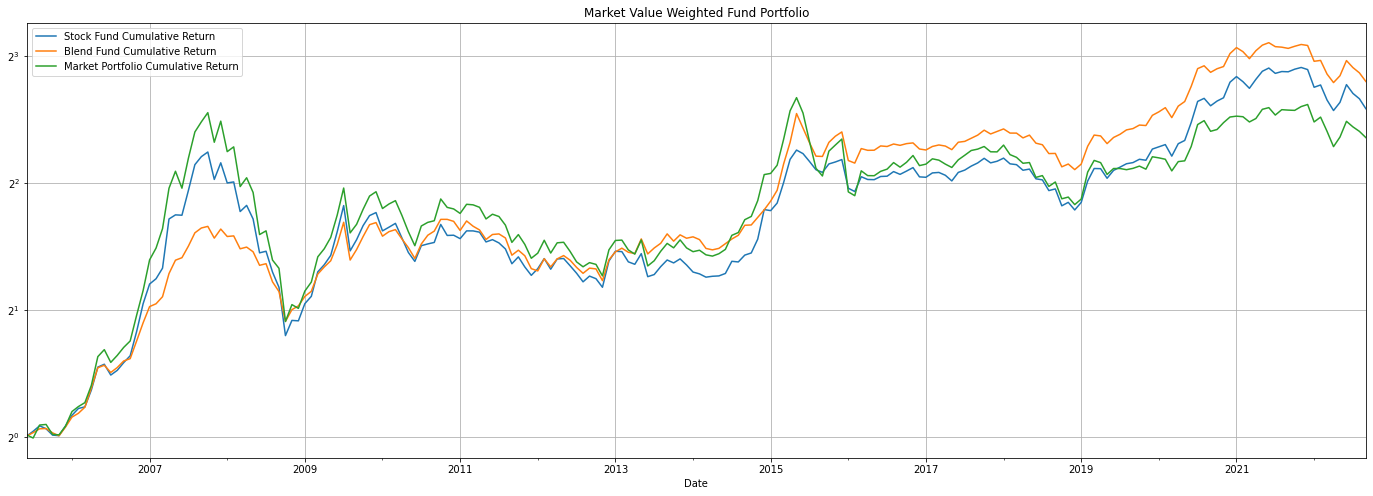

In [46]:
plt.figure(figsize=(24,8))

# TODO: 高收益混合型基金收益来源
(((return_of_stock_fund.unstack(level=0) - 1) * stock_fund_weight).sum(axis=1) + 1).loc['2005-6':].cumprod().plot(label='Stock Fund Cumulative Return')
(((return_of_blend_fund.unstack(level=0) - 1) * blend_fund_weight).sum(axis=1) + 1).loc['2005-6':].cumprod().plot(label='Blend Fund Cumulative Return')
((svc_source.loc['2005-6': ].mktrf + svc_source.loc['2005-6': ].rf) + 1).cumprod().plot(label='Market Portfolio Cumulative Return')

plt.yscale('log', base=2)
plt.title('Market Value Weighted Fund Portfolio')
plt.grid()
plt.legend()

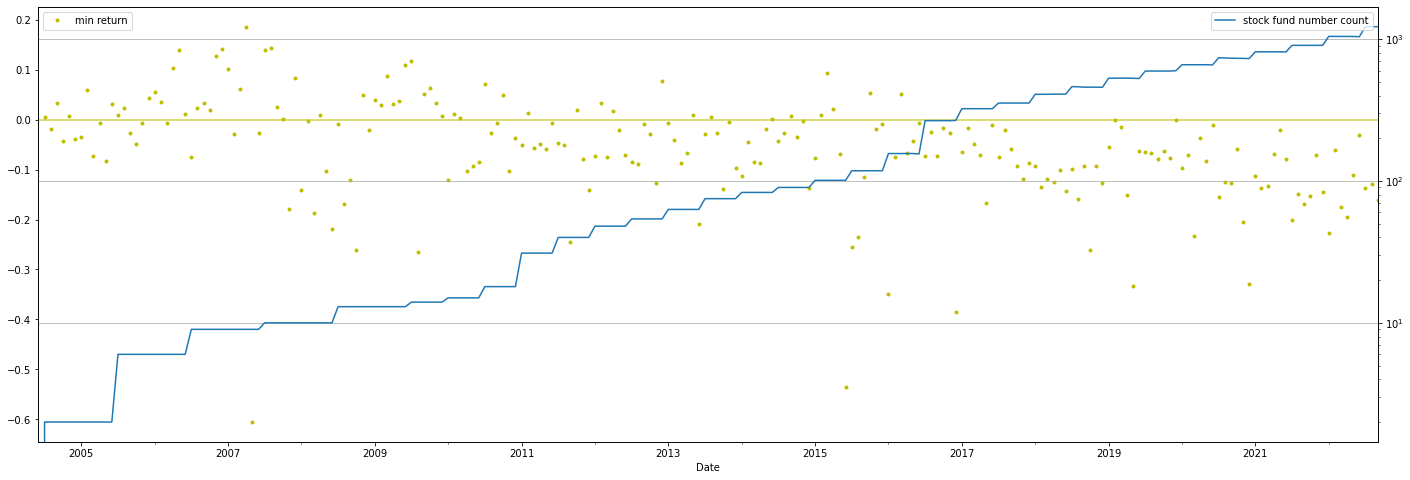

In [47]:
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(24)
(return_of_stock_fund.unstack(0) - 1).T.describe().loc['min'].plot(ax=ax1, style='.', label='min return', color='y')
ax1.legend()
ax1.legend(loc='upper left')
ax1.axhline(color='y', alpha=.7)
ax2 = ax1.twinx()
(return_of_stock_fund.unstack(0) - 1).T.describe().loc['count'].plot(ax=ax2, label='stock fund number count')
ax2.grid()
ax2.set_yscale('log')
ax2.legend(loc='upper right')

In [48]:
# plt.figure(figsize=(24,8))
# return_of_stock_fund.groupby(level=1).mean().loc['2005-6':].cumprod().plot(label='Stock Fund Cumulative Return')
# return_of_blend_fund.groupby(level=1).mean().loc['2005-6':].cumprod().plot(label='Blend Fund Cumulative Return')
# plt.yscale('log', base=2)
# plt.title('1/N Weighted Fund Portfolio')
# plt.grid()
# plt.legend()

why use data later than 2005-06?

In [49]:
co_time = np.intersect1d(share_info_.index, nav_monthly.index)
co_stocks = np.intersect1d(share_info_.columns, nav_monthly.columns)
compare_share_info = share_info_.loc[co_time, co_stocks]
compare_nav_monthly = nav_monthly.loc[co_time, co_stocks]

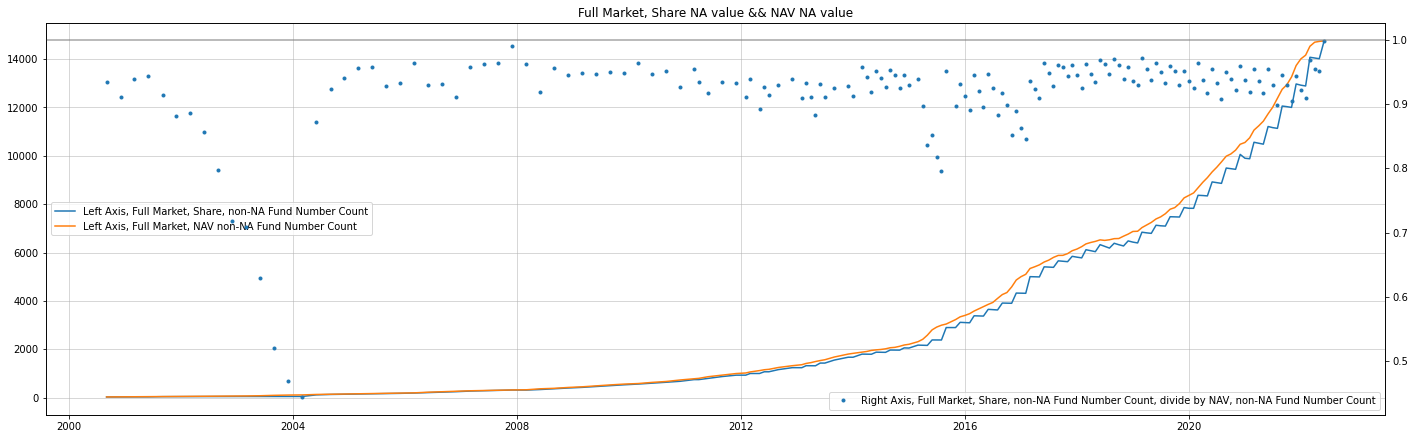

In [50]:
filled_share_info = compare_share_info.fillna(method='ffill')
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(24)
def na_compare(row):
    date = row.name
    available_funds = row.dropna().index
    selected_share_info = (row * filled_share_info.loc[date]).dropna()
    available_share_funds = selected_share_info.index

    return [len(available_share_funds), len(available_funds)]

temp = np.array(list(compare_nav_monthly.apply(na_compare, axis=1).values))
ax1.plot(compare_nav_monthly.index.astype(np.datetime64), temp[:, 0], label='Left Axis, Full Market, Share, non-NA Fund Number Count')
ax1.plot(compare_nav_monthly.index.astype(np.datetime64), temp[:, 1], label='Left Axis, Full Market, NAV non-NA Fund Number Count')
ax1.legend(loc='center left')
ax1.grid(linewidth=.5)

ax2 = ax1.twinx()

pd.Series(temp[:, 0] / temp[:, 1] ,index=compare_nav_monthly.index.astype(np.datetime64)).plot(style='.', label='Right Axis, Full Market, Share, non-NA Fund Number Count, divide by NAV, non-NA Fund Number Count')
plt.title('Full Market, Share NA value && NAV NA value')
ax2.legend(loc='lower right')

ax2.axhline(y=1, color='grey', alpha=.7)


Size effect in fund?

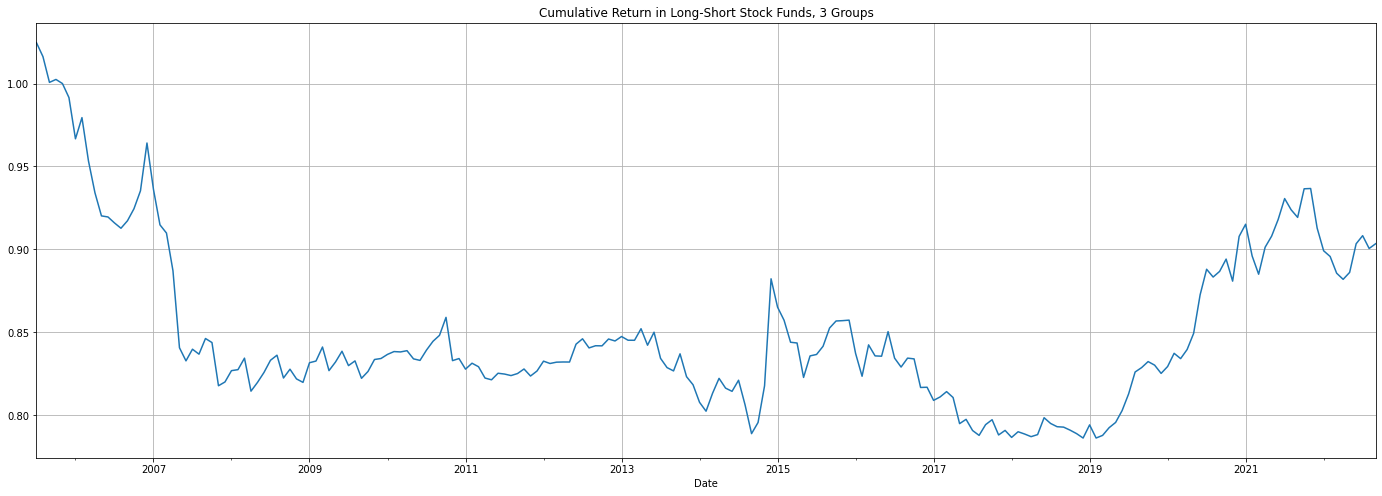

In [51]:
stock_fund_weight_ = (share_info_6.loc[csmar_co_time_6, csmar_stock_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_stock_code_6])
stock_fund_weight_ = pd.concat([stock_fund_weight_, \
    pd.DataFrame([[np.nan] * stock_fund_weight_.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=stock_fund_weight_.columns)])
stock_fund_weight_ = stock_fund_weight_.resample('M').ffill()

groups = 3
ret_stock_fund = return_of_stock_fund.unstack(0) - 1
stock_fund_groups = stock_fund_weight_.dropna(how='all').apply(lambda x: pd.qcut(x, groups, labels=np.arange(groups)) if not pd.isna(x).all() else x, axis=1)
co_time = np.intersect1d(stock_fund_groups.index, ret_stock_fund.index)
co_stocks = np.intersect1d(stock_fund_groups.columns, ret_stock_fund.columns)

stock_fund_groups = stock_fund_groups.loc[co_time, co_stocks]
ret_stock_fund = ret_stock_fund.loc[co_time, co_stocks]

def func(x):
    date = x.name
    result = pd.DataFrame([x, stock_fund_groups.loc[date]], index=['return', 'rank']).T.groupby('rank').mean().iloc[:, 0]
    if result.shape[0] < groups:
        
        return pd.Series([np.nan] * groups, name=date)
    else:
        return result

stock_grouped_return = ret_stock_fund.apply(func, axis=1).dropna()
plt.figure(figsize=(24, 8))
plt.title(f'Cumulative Return in Long-Short Stock Funds, {groups} Groups')
(stock_grouped_return.iloc[:, -1] - stock_grouped_return.iloc[:, 0] + 1).cumprod().plot()
plt.grid()

In [52]:
stats.ttest_1samp((stock_grouped_return.iloc[:, -1] - stock_grouped_return.iloc[:, 0]).dropna(), 0, alternative ='greater')

Ttest_1sampResult(statistic=-0.4363630368132899, pvalue=0.6684848318998369)

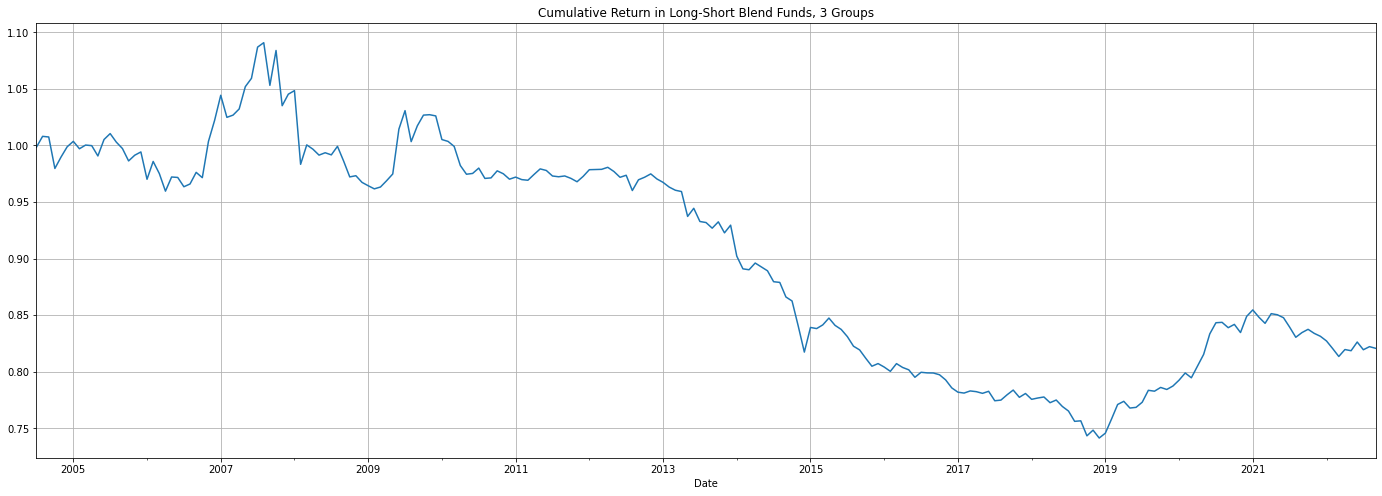

In [53]:
blend_fund_weight_ = (share_info_6.loc[csmar_co_time_6, csmar_blend_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_blend_code_6])
blend_fund_weight_ = pd.concat([blend_fund_weight_, \
    pd.DataFrame([[np.nan] * blend_fund_weight_.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=blend_fund_weight_.columns)])
blend_fund_weight_ = blend_fund_weight_.resample('M').ffill()

groups = 3
ret_blend_fund = return_of_blend_fund.unstack(0) - 1
blend_fund_groups = blend_fund_weight_.dropna(how='all').apply(lambda x: pd.qcut(x, groups, labels=np.arange(groups)) if not pd.isna(x).all() else x, axis=1)
co_time = np.intersect1d(blend_fund_groups.index, ret_blend_fund.index)
co_stocks = np.intersect1d(blend_fund_groups.columns, ret_blend_fund.columns)

blend_fund_groups = blend_fund_groups.loc[co_time, co_stocks]
ret_blend_fund = ret_blend_fund.loc[co_time, co_stocks]

def func(x):
    date = x.name
    result = pd.DataFrame([x, blend_fund_groups.loc[date]], index=['return', 'rank']).T.groupby('rank').mean().iloc[:, 0]
    if result.shape[0] < groups:
        
        return pd.Series([np.nan] * groups, name=date)
    else:
        return result
plt.figure(figsize=(24, 8))
plt.title(f'Cumulative Return in Long-Short Blend Funds, {groups} Groups')
blend_grouped_return = ret_blend_fund.apply(func, axis=1).dropna()

(blend_grouped_return.iloc[:, -1] - blend_grouped_return.iloc[:, 0] + 1).cumprod().plot()
plt.grid()

In [54]:
stats.ttest_1samp((blend_grouped_return.iloc[:, -1] - blend_grouped_return.iloc[:, 0]).dropna(), 0, alternative ='greater')

Ttest_1sampResult(statistic=-1.0556523974666998, pvalue=0.8538522254956163)

### Regression

regression table construction

In [55]:
# market value weighted
stock_fund_regression = ((return_of_stock_fund.unstack(level=0) - 1) * stock_fund_weight).sum(axis=1)
stock_fund_regression.name = 'stock_fund'

blend_fund_regression = ((return_of_blend_fund.unstack(level=0) - 1) * blend_fund_weight).sum(axis=1)
blend_fund_regression.name = 'blend_fund'

# 1/N weighted
# stock_fund_regression = return_of_stock_fund.groupby(level=1).mean().dropna() - 1
# stock_fund_regression.name = 'stock_fund'

# blend_fund_regression = return_of_blend_fund.groupby(level=1).mean().dropna() - 1
# blend_fund_regression.name = 'blend_fund'

regression_source = pd.merge(stock_fund_regression, svc_source[['mktrf', 'rf', 'smb', 'vmg']], on='Date')
regression_source = pd.merge(regression_source, blend_fund_regression, on='Date')

# regression_source *= 100
regression_source['α'] = 1

regression_source = regression_source.loc['2005/6':]
regression_source

,stock_fund,mktrf,rf,smb,vmg,blend_fund,α
Date,,,,,,,
2005-06,0.006722,0.011522,0.001856,0.000517,0.056121,0.006346,1
2005-07,0.026240,-0.019041,0.001856,-0.051082,0.071114,0.019213,1
2005-08,0.030586,0.071589,0.001856,0.094712,-0.049516,0.021038,1
2005-09,-0.016050,0.001288,0.001856,0.033242,0.045120,0.001627,1
2005-10,-0.034043,-0.054595,0.001856,-0.001480,0.024557,-0.023199,1
...,...,...,...,...,...,...,...
2022-05,0.045655,0.052554,0.001241,0.064625,-0.012790,0.038071,1
2022-06,0.101454,0.088114,0.001241,-0.020506,-0.028009,0.086118,1
2022-07,-0.046780,-0.030989,0.001241,0.071198,-0.005291,-0.037448,1


naïve regression

In [56]:
stock_naïve = sm.OLS(regression_source.stock_fund, regression_source[['α']]).fit()
blend_naïve = sm.OLS(regression_source.blend_fund, regression_source[['α']]).fit()
stock_naïve_excess = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α']]).fit()
blend_naïve_excess = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α']]).fit()

In [57]:
pd.DataFrame(
[
[float_to_percent(stock_naïve.params[0]), stock_naïve.tvalues.iloc[0].round(3), stock_naïve.pvalues[0].round(3), yearly_return(stock_naïve)],
[float_to_percent(blend_naïve.params[0]), blend_naïve.tvalues.iloc[0].round(3), blend_naïve.pvalues[0].round(3), yearly_return(blend_naïve)],
[float_to_percent(stock_naïve_excess.params[0]), stock_naïve_excess.tvalues.iloc[0].round(3), stock_naïve_excess.pvalues[0].round(3), yearly_return(stock_naïve_excess)],
[float_to_percent(blend_naïve_excess.params[0]), blend_naïve_excess.tvalues.iloc[0].round(3), blend_naïve_excess.pvalues[0].round(3), yearly_return(blend_naïve_excess)],
],
index=['stock_naïve', 'blend_naïve', 'stock_naïve_excess', 'blend_naïve_excess'], columns=pd.Series(['α', 't', 'p', 'annual α'],\
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}'))

2005/6-2022/9,α,t,p,annual α
stock_naïve,1.091%,2.328,0.021,13.91%
blend_naïve,1.076%,2.930,0.004,13.71%
stock_naïve_excess,0.901%,1.921,0.056,11.36%
blend_naïve_excess,0.886%,2.410,0.017,11.17%


CAPM regression

In [58]:
stock_capm = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α', 'mktrf']]).fit()
blend_capm = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α', 'mktrf']]).fit()

In [59]:
pd.DataFrame(
[
[float_to_percent(stock_capm.params[0]) + ' (' + str(stock_capm.tvalues.iloc[0].round(3)) + ')', \
    str(stock_capm.params[1].round(3)) + ' (' + str(stock_capm.tvalues.iloc[1].round(3)) + ')',\
         stock_capm.rsquared, yearly_return(stock_capm)],
[float_to_percent(blend_capm.params[0]) + ' (' + str(blend_capm.tvalues.iloc[0].round(3)) + ')', \
    str(blend_capm.params[1].round(3)) + ' (' + str(blend_capm.tvalues.iloc[1].round(3)) + ')', \
        blend_capm.rsquared, yearly_return(blend_capm)],
],
columns=['α', 'mktrf', 'r^2', 'annual α'], index=pd.Series(['stock_capm', 'blend_capm'], \
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}')).T

2005/6-2022/9,stock_capm,blend_capm
α,0.154% (1.052),0.325% (2.128)
mktrf,0.826 (44.307),0.62 (31.82)
r^2,0.905032,0.830937
annual α,1.86%,3.97%


SVC regression

In [60]:
stock_svc = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α', 'mktrf', 'smb', 'vmg']]).fit()
blend_svc = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α', 'mktrf', 'smb', 'vmg']]).fit()

In [61]:
pd.DataFrame(
[
[float_to_percent(stock_svc.params[0]) + ' (' + str(stock_svc.tvalues.iloc[0].round(3)) + ')', \
    str(stock_svc.params[1].round(3)) + ' (' + str(stock_svc.tvalues.iloc[1].round(3)) + ')', \
        str(stock_svc.params[2].round(3)) + ' (' + str(stock_svc.tvalues.iloc[2].round(3)) + ')', \
            str(stock_svc.params[3].round(3)) + ' (' + str(stock_svc.tvalues.iloc[3].round(3)) + ')', \
                stock_svc.rsquared, yearly_return(stock_svc)],
[float_to_percent(blend_svc.params[0]) + ' (' + str(blend_svc.tvalues.iloc[0].round(3)) + ')', \
    str(blend_svc.params[1].round(3)) + ' (' + str(blend_svc.tvalues.iloc[1].round(3)) + ')', \
        str(blend_svc.params[2].round(3)) + ' (' + str(blend_svc.tvalues.iloc[2].round(3)) + ')', \
            str(blend_svc.params[3].round(3)) + ' (' + str(blend_svc.tvalues.iloc[3].round(3)) + ')', \
                blend_svc.rsquared, yearly_return(blend_svc)],
],
# 乘100
columns=['α', 'mktrf', 'smb', 'vmg', 'r^2', 'annual α'], index=pd.Series(['stock_svc', 'blend_svc'], \
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}')).T

2005/6-2022/9,stock_svc,blend_svc
α,0.323% (2.165),0.67% (4.294)
mktrf,0.838 (46.938),0.592 (31.72)
smb,-0.179 (-5.55),-0.063 (-1.867)
vmg,-0.024 (-0.569),-0.263 (-5.967)
r^2,0.919562,0.856929
annual α,3.95%,8.35%


In [62]:
X = regression_source[['α', 'mktrf', 'smb', 'vmg']]
y = regression_source.stock_fund - regression_source.rf

$\vec{\hat{y}} = \boldsymbol{X}\vec{\hat{β}}$

$SSE = \sum_{i=1}^{n}(y_i-\hat{y_i})^2$

In [63]:
SSE = ((y - X @ stock_svc.params) ** 2).sum()

$\hat{σ}=\sqrt{\dfrac{SSE}{n-p-1}}$

In [64]:
σ_hat = (SSE / (X.shape[0] - X.shape[1])) ** .5

$\vec{c_{ij}}=(\boldsymbol{X^T}\boldsymbol{X})^{-1}$

In [65]:
c_ii = np.linalg.inv(X.T @ X).diagonal()

$\vec{t}=\dfrac{\vec{\hat{β}}}{\sqrt{\vec{c_{ij}}}\hat{σ}}$

In [66]:
stock_svc.params / (c_ii  ** .5 * σ_hat)

α         2.164585
mktrf    46.937742
smb      -5.549842
vmg      -0.569241
dtype: float64

## **V. Fund Evaluation**

### Method

step1, α, 每支基金，2005-2022滚动回归，窗口期3年，得到α面板数据

| date/fund | fund1 | fund2 | fund3 |
| --------- | ----- | ----- | ----- |
| date1     | 0.1   | 0.1   | 0.1   |
| date2     | 0.1   | 0.1   | 0.1   |
| date3     | 0.1   | 0.1   | 0.1   |

step2, fund_list, 每个日期，对上述α面板数据分低中高3组。保留每个日期中，低中高3组α对应的3个基金组合

| date/group | low                         | middle | high   |
| ---------- | --------------------------- | ------ | ------ |
| date1      | [ fund1, fund2, fund3, … ] | [ … ] | [ … ] |
| date2      | [ … ]                      | [ … ] | [ … ] |
| date3      | [ … ]                      | [ … ] | [ … ] |

step3, return, 对上述基金列表面板数据，对每个日期、每组基金，乘以其市值加权权重（市值与权重成正比），得到加权收益率

| date/group | low | middle | high |
| ---------- | --- | ------ | ---- |
| date1      | 0.1 | 0.1    | 0.1  |
| date2      | 0.1 | 0.1    | 0.1  |
| date3      | 0.1 | 0.1    | 0.1  |

step4, summary, 对上述收益率面板数据，按基金组别，与既有模型回归

| indicator/group | low | middle | high |
| --------------- | --- | ------ | ---- |
| α              | 0.1 | 0.1    | 0.1  |
| t               | 1   | 1      | 1    |

step5, summary, 整合多个模型统计结果

|   model-indicator/group     | model-indicator/group | low | middle | high |
| ------ | --------------------- | --- | ------ | ---- |
| model1 | α                    | 0.1 | 0.1    | 0.1  |
|        | t                     | 1   | 1      | 1    |
| model2 | α                    | 0.1 | 0.1    | 0.1  |
|        | t                     | 1   | 1      | 1    |
| model3 | α                    | 0.1 | 0.1    | 0.1  |
|        | t                     | 1   | 1      | 1    |

### Utilities

In [67]:
all_fund_weight = share_info_6 * nav_monthly_6
all_fund_weight = pd.concat([all_fund_weight, \
    pd.DataFrame([[np.nan] * all_fund_weight.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=all_fund_weight.columns)])
all_fund_weight = all_fund_weight.resample('M').ffill()

In [68]:
return_of_all_fund_ = (return_of_all_fund.unstack(0) - 1).loc['2005-6': '2019-6']

In [69]:


def group_and_statistic(α_matrix, GROUPS = 5):

    grouped_all_fund_α_matrix = α_matrix.apply(lambda x: \
        pd.qcut(x, GROUPS, labels=np.arange(GROUPS)) if pd.notna(x).sum() >= GROUPS else pd.Series([np.nan] * len(x), x.index), axis=1).dropna(how='all')

    def func(x):
        date = x.name
        weight = all_fund_weight.loc[date]
        return_look_forward = return_of_all_fund_.shift(-1)
        ret = return_look_forward.loc[date]

        result = pd.DataFrame([x, ret, weight], index=['rank', 'ret', 'weight']).T.dropna(subset='rank').sort_values(by='rank')
        result['weight'] = result.groupby('rank').apply(lambda y: y.weight / y.weight.sum()).values
        result = result.groupby('rank').apply(lambda y: (y.ret * y.weight).sum())
        return result

    grouped_all_fund_α_matrix_return = grouped_all_fund_α_matrix.apply(func, axis=1)


    # RS denotes regression source
    RS_α = pd.merge(grouped_all_fund_α_matrix_return, regression_source, on='Date')
    RS_α[['stock_fund', 'mktrf', 'rf', 'smb', 'vmg', 'blend_fund']] = RS_α[['stock_fund', 'mktrf', 'rf', 'smb', 'vmg', 'blend_fund']].shift(-1)
    RS_α = RS_α.iloc[:-1]

    regressors = [
        ['α'],
        ['α', 'mktrf'],
        ['α', 'mktrf', 'smb', 'vmg']
        ]
        
    results = []

    for regressor in regressors:

        for group in range(GROUPS):
            temp = sm.OLS(RS_α[group] - RS_α.rf, RS_α[regressor]).fit()
            results.append([float_to_percent(temp.params[0]), yearly_return(temp), temp.tvalues[0].round(3), temp.rsquared.round(3)])
        # remove r_f
        temp = sm.OLS(RS_α[GROUPS - 1] - RS_α[0], RS_α[regressor]).fit()
        results.append([float_to_percent(temp.params[0]), yearly_return(temp), temp.tvalues[0].round(3), temp.rsquared.round(3)])

    excess_result, capm_α_result, svc_α_result = results[0: GROUPS + 1], results[GROUPS + 1: 2 * GROUPS + 2], results[2 * GROUPS + 2: 3 * GROUPS + 3]

    excess_result = pd.DataFrame(np.array(excess_result).T, \
        index=pd.MultiIndex.from_product([['excess'], ['α (monthly)', 'annual α', 't', 'R^2']]), columns=['group' + str(i) for i in range(GROUPS)] + ['long-short'])
    capm_α_result = pd.DataFrame(np.array(capm_α_result).T, \
        index=pd.MultiIndex.from_product([['capm α'], ['α (monthly)', 'annual α', 't', 'R^2']]), columns=['group' + str(i) for i in range(GROUPS)] + ['long-short'])
    svc_α_result = pd.DataFrame(np.array(svc_α_result).T, \
        index=pd.MultiIndex.from_product([['svc α'], ['α (monthly)', 'annual α', 't', 'R^2']]), columns=['group' + str(i) for i in range(GROUPS)] + ['long-short'])

    return pd.concat([excess_result, capm_α_result, svc_α_result])


def fund_ended_check(α_operation):
    def check_filter(x):
        if pd.notna(x[-1]):
            # if the fund is running now
            return α_operation(x)
        else:
            # if the fund is shut down
            return np.nan
    return check_filter


@fund_ended_check
def α_na_ratio(x):

    window_length = len(x)
    x = x.dropna()  
    return 1 - len(x) / window_length


    

In [70]:
MAX_NA_NUM = 35

return_of_all_fund_na_ratio = return_of_all_fund_.rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(α_na_ratio)
return_of_all_fund_na_ratio

Symbol,000001,000006,000011,000017,000020,000021,000029,000030,000031,000039,...,960016,960018,960020,960021,960022,960023,960024,960026,960028,960033
Date,,,,,,,,,,,,,,,,,,,,,
2005-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-07,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-08,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-09,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-10,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,0.277778,0.277778,0.277778,0.777778,NaN,NaN,0.444444,NaN,0.444444,0.777778
2019-03,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,0.250000,0.250000,0.250000,0.750000,NaN,NaN,0.416667,NaN,0.416667,0.750000
2019-04,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,0.222222,0.222222,0.222222,0.722222,NaN,NaN,0.388889,NaN,0.388889,0.722222


### last 3 years' excess return on CAPM

In [69]:
@fund_ended_check
def capm_α_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    α = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf']]).fit().params[0]
    return α

all_fund_capm_α = return_of_all_fund_.rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(capm_α_generation)

In [70]:
group_and_statistic(all_fund_capm_α)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.942%   1.07%   1.08%  1.257%  1.205%     0.263%
       annual α     11.91%  13.63%  13.76%  16.17%  15.45%       3.2%
       t             1.686   1.907   1.933   2.232   2.075      1.482
       R^2            -0.0     0.0    -0.0     0.0    -0.0       -0.0
capm α α (monthly)  0.091%  0.222%  0.243%  0.471%  0.377%     0.286%
       annual α       1.1%   2.69%   2.95%    5.8%   4.62%      3.49%
       t             0.646   1.416    1.41   1.791    1.52      1.605
       R^2           0.938   0.924   0.907   0.787   0.821      0.007
svc α  α (monthly)  0.159%  0.323%  0.405%  0.524%  0.645%     0.486%
       annual α      1.92%   3.94%   4.97%   6.47%   8.02%      5.99%
       t             0.996   1.812   2.092   1.713   2.346       2.41
       R^2           0.942   0.928   0.914   0.788   0.839       0.07

### last 3 years' excess return on SVC

In [71]:
@fund_ended_check
def svc_α_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    α = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf', 'smb', 'vmg']]).fit().params[0]
    return α

all_fund_svc_α = return_of_all_fund_.rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(svc_α_generation)

In [72]:
group_and_statistic(all_fund_svc_α)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.957%  1.064%  1.071%  1.308%  1.134%     0.177%
       annual α     12.11%  13.54%  13.63%  16.88%  14.49%      2.15%
       t             1.682   1.932   1.941    2.25   1.975      1.055
       R^2            -0.0    -0.0    -0.0     0.0    -0.0        0.0
capm α α (monthly)  0.091%  0.229%  0.243%   0.51%  0.311%      0.22%
       annual α       1.1%   2.79%   2.96%    6.3%    3.8%      2.67%
       t             0.626   1.531   1.442   1.777   1.302      1.315
       R^2           0.936   0.927   0.908   0.761    0.83      0.026
svc α  α (monthly)  0.039%  0.242%    0.4%    0.6%  0.661%     0.621%
       annual α      0.47%   2.94%   4.91%   7.44%   8.22%      7.71%
       t             0.233   1.401   2.127   1.799   2.541      3.648
       R^2           0.937    0.93   0.916   0.764   0.853      0.263

### industry concentration

In [71]:
classification = pd.read_csv('data/CSMAR/TRD_Co.csv')

In [105]:
invest_detail = ddf.read_csv('data/CSMAR/invest_detail/*', low_memory=False, dtype={'Symbol': 'object'}).compute()
invest_detail = invest_detail.rename(columns={'Symbol': 'Stkcd'})
def aboard_stock(x):
    try:
        int(x)
        return False
    except:
        return True

# 1.8% aboard_stock dropped
aboard_stock_filter = invest_detail.Stkcd.apply(aboard_stock)
invest_detail = invest_detail[~ aboard_stock_filter]
invest_detail = pd.merge(invest_detail, symbol_code_mapping.groupby('MasterFundCode').last(), on='MasterFundCode', how='left', validate='m:1')
invest_detail['Stkcd'] = invest_detail.Stkcd.astype(int)
invest_detail = pd.merge(invest_detail, classification[['Stkcd', 'Indnme']], on='Stkcd', validate='m:1')

invest_detail = invest_detail.rename(columns={'EndDate': 'Date'})
invest_detail['Date'] = pd.to_datetime(invest_detail.Date).dt.to_period('M')

invest_detail = invest_detail[['Date', 'Symbol', 'Indnme', 'Proportion', 'ReportTypeID', 'Stkcd', 'StockName']]
invest_industry_sum = invest_detail.groupby(['Symbol', 'Date', 'Indnme']).apply(lambda x: x.Proportion.sum())

invest_industry_proportion = invest_industry_sum / invest_industry_sum.groupby(level=[0, 1]).sum()
invest_industry_proportion = invest_industry_proportion.unstack(level=[0, 2]).resample('M').ffill().fillna(method='ffill')
invest_industry_proportion = invest_industry_proportion.stack(0).swaplevel().sort_index().fillna(0)

In [116]:
month_mkt_value = pd.read_csv('data/CSMAR/TRD_Mnth.csv')
month_mkt_value = pd.merge(month_mkt_value, classification, on='Stkcd', validate='m:1')
month_mkt_value = month_mkt_value.groupby(['Trdmnt', 'Indnme']).apply(lambda x: x.Msmvttl.sum())
month_mkt_value = month_mkt_value.unstack().div(month_mkt_value.unstack().sum(axis=1), axis=0).fillna(0)
month_mkt_value.index = pd.to_datetime(month_mkt_value.index).to_period('M')
month_mkt_value.index.name = 'Date'
month_mkt_value = pd.merge(invest_industry_proportion.reset_index()[['Symbol', 'Date']], month_mkt_value, on='Date')\
    .set_index(['Symbol', 'Date']).sort_index()

Indnme              公用事业        商业        工业       房地产        综合        金融
Symbol Date                                                               
000001 2002-03  0.155654  0.068701  0.613242  0.092060  0.026749  0.043595
       2002-04  0.155306  0.068864  0.603982  0.090650  0.025712  0.055485
       2002-05  0.159220  0.067568  0.605567  0.088785  0.024681  0.054179
       2002-06  0.155224  0.066079  0.605700  0.090146  0.024409  0.058442
       2002-07  0.157237  0.067617  0.601294  0.090411  0.023976  0.059465
...                  ...       ...       ...       ...       ...       ...
970121 2022-09  0.124558  0.020137  0.665292  0.036775  0.012576  0.140661
970126 2022-06  0.123718  0.020448  0.665322  0.036829  0.011916  0.141767
       2022-07  0.123910  0.020222  0.673685  0.035785  0.012920  0.133478
       2022-08  0.124436  0.020273  0.668596  0.036049  0.013248  0.137398
       2022-09  0.124558  0.020137  0.665292  0.036775  0.012576  0.140661

[451255 rows x 6 columns]

In [117]:
industry_concentration = ((invest_industry_proportion - month_mkt_value) ** 2).sum(axis=1)
industry_concentration = industry_concentration.unstack().T
industry_concentration